<a href="https://colab.research.google.com/github/sana1410/Natural-Language-Processing/blob/main/EAI6010_Assignment3_Sana_Yasin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using FastAI ULMFiT to complete your assignment


## 0. Setup

In [43]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [44]:
# Installing and importing the necessary libraries
!pip install fastai --quiet
!pip install kaggle --quiet

from fastai.text.all import *

import warnings
warnings.filterwarnings('ignore')

In [45]:
pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Import the data

In [46]:
# Loaded dataset and lables after creating the folder structure as shown below in Google
label_path = '/content/gdrive/MyDrive/Colab Notebooks/label_StackOverflow.txt'
text_path = '/content/gdrive/MyDrive/Colab Notebooks/title_StackOverflow.txt'

df_text = pd.read_csv(text_path, sep='\t', names=['text'], header=None, on_bad_lines='skip')
df_label = pd.read_csv(label_path, sep='\t', names=['label'], header=None)

df = pd.concat([df_label, df_text], axis=1, sort=False)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [47]:
mapping = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}

df['label'] = df['label'].map(mapping)

df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


## 2. Create train & validation datasets and FastAI data bunch

In [48]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3)

df_trn.shape, df_val.shape

((14000, 2), (6000, 2))

In [49]:
df_trn.head()

,label,text
685,bash,Real-time history export amongst bash terminal windows
13780,apache,MATLAB How to divide a matrix into equals parts?
8506,drupal,drupal file sharing
4690,linq,How to simplify this LINQ Query with Distinct on each column into a single statement
2363,ajax,Cross domain Ajax request from within js file.


In [50]:
# Concatenate the label and the text data
df = pd.concat([df_label, df_text], axis=1, sort=False)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [51]:
# Extract the text data only
df_lm = pd.concat([df_trn, df_val], axis=0)[['text']]
df_lm.head()

,text
685,Real-time history export amongst bash terminal windows
13780,MATLAB How to divide a matrix into equals parts?
8506,drupal file sharing
4690,How to simplify this LINQ Query with Distinct on each column into a single statement
2363,Cross domain Ajax request from within js file.


In [52]:
# Creating a dataloader for self-supervised learning task
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1))

In [53]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

In [54]:
dls_lm.show_batch(max_n = 3)

,text,text_
0,xxbos xxmaj how to extract a meta tag from xxup xml / xxup html using xxmaj linq ? xxbos xxmaj how can i send an xxup http xxup post request to a server from xxmaj excel using xxup vba ? xxbos [ drupal ] xxmaj how do i give a specific user editing rights to a specific node ? xxbos xxmaj document is not updated after check in form xxmaj word xxbos,xxmaj how to extract a meta tag from xxup xml / xxup html using xxmaj linq ? xxbos xxmaj how can i send an xxup http xxup post request to a server from xxmaj excel using xxup vba ? xxbos [ drupal ] xxmaj how do i give a specific user editing rights to a specific node ? xxbos xxmaj document is not updated after check in form xxmaj word xxbos xxmaj
1,i xxunk this ? xxbos xxmaj delete a xxmaj web that does n't exist . xxbos xxmaj oracle xxmaj query xxmaj optimization xxbos xxmaj how to force magento to use full product path ? xxbos xxmaj is there a convention for naming ' private functions ' in bash ? xxbos xxmaj is it true xxup linq is getting xxunk ? xxbos xxmaj change version xxunk in a built binary xxbos xxmaj good,xxunk this ? xxbos xxmaj delete a xxmaj web that does n't exist . xxbos xxmaj oracle xxmaj query xxmaj optimization xxbos xxmaj how to force magento to use full product path ? xxbos xxmaj is there a convention for naming ' private functions ' in bash ? xxbos xxmaj is it true xxup linq is getting xxunk ? xxbos xxmaj change version xxunk in a built binary xxbos xxmaj good techniques
2,sbt ? xxbos xxmaj wordpress - xxmaj create a splash screen without affecting search engine results xxbos xxmaj how to xxunk output in a xxup bash script ? xxbos xxmaj writing a time function in xxmaj haskell xxbos xxmaj why is xxmaj visual xxmaj studio constantly crashing ? ! xxbos sharepoint and deployment of xxunk code xxbos xxmaj xxunk to xxmaj drupal in production xxbos xxmaj drupal xxmaj array of xxmaj inputs,? xxbos xxmaj wordpress - xxmaj create a splash screen without affecting search engine results xxbos xxmaj how to xxunk output in a xxup bash script ? xxbos xxmaj writing a time function in xxmaj haskell xxbos xxmaj why is xxmaj visual xxmaj studio constantly crashing ? ! xxbos sharepoint and deployment of xxunk code xxbos xxmaj xxunk to xxmaj drupal in production xxbos xxmaj drupal xxmaj array of xxmaj inputs xxbos


## 3. Create and Train the Language Model

In [55]:
# Define the language model
learn = language_model_learner(dls_lm,AWD_LSTM, drop_mult=0.5, metrics=[accuracy,Perplexity()]).to_fp16()

SuggestedLRs(valley=0.00363078061491251)

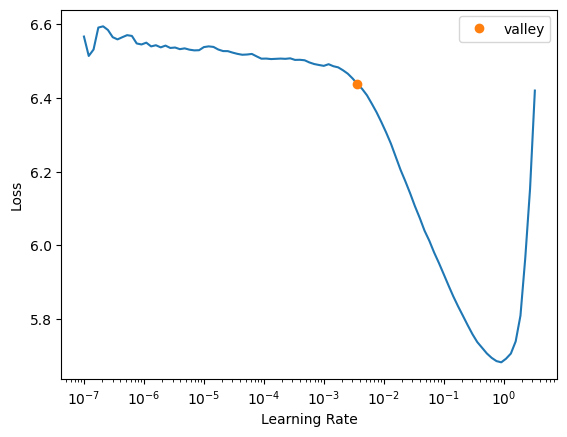

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.612031,4.157438,0.305322,63.907570,00:15


In [58]:
learn.unfreeze()

In [59]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.017736,4.019061,0.325056,55.648830,00:16
1,3.916716,3.987414,0.328035,53.915302,00:16
2,3.795052,3.845284,0.341870,46.771988,00:16
3,3.674671,3.819176,0.344412,45.566631,00:17
4,3.521171,3.815895,0.345103,45.417389,00:16
5,3.370080,3.830734,0.344807,46.096340,00:15
6,3.238193,3.868301,0.343113,47.860985,00:16
7,3.131887,3.892560,0.343877,49.036259,00:16
8,3.051490,3.910740,0.342067,49.935886,00:15
9,3.003438,3.914596,0.342309,50.128796,00:15


In [60]:
#Save the encoder
learn.save_encoder('fine_tuned_enc')

## 4. Using the Language Model to Train the Classifier

In [61]:
#Creating dataloader for classsifier

dls_class = DataBlock(blocks=(TextBlock.from_df('text', seq_len = dls_lm.seq_len, vocab = dls_lm.vocab), CategoryBlock), get_x = ColReader('text'),get_y = ColReader('label'), splitter = RandomSplitter(0.1)).dataloaders(df, bs=64)

In [62]:
#Defining classifier
classifier = text_classifier_learner(
    dls_class, AWD_LSTM, drop_mult = 0.5, metrics = accuracy).to_fp16()
classifier.load_encoder('fine_tuned_enc')

SuggestedLRs(valley=0.004365158267319202)

epoch,train_loss,valid_loss,accuracy,time
0,2.258924,2.065566,0.447500,00:24


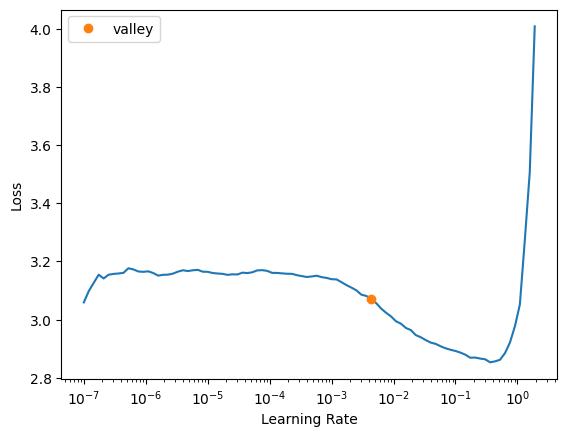

In [63]:
# Applying unfreezing of one layer after another
classifier.lr_find()
classifier.fit_one_cycle(1,2e-2)


In [64]:
classifier.freeze_to(-2)

In [65]:
classifier.fit_one_cycle(1,slice(1e-2/2.6**4),1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.186487,2.082117,0.436500,00:25


In [66]:
learn.unfreeze()

In [67]:
classifier.fit_one_cycle(2,slice(1e-3/2.6**4),1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.090060,2.001646,0.457000,00:25
1,2.060268,2.003146,0.459000,00:25


## 5. Analyzing our results

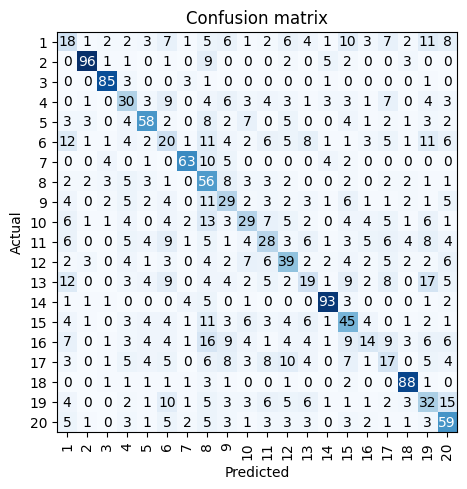

In [68]:
inter_p = ClassificationInterpretation.from_learner(classifier)
inter_p. plot_confusion_matrix()

## 6. Predictions

In [69]:
ex_ques = "How do I fix an SVN checkout error?"
pred, _, probs = classifier.predict(ex_ques)
print(f"Prediction: {pred}, probability: {max(probs.numpy())}")

Prediction: 3, probability: 0.9629793167114258


## 7. Export the model

In [70]:
classifier.export('/content/gdrive/MyDrive/Colab Notebooks/stackoverflow_classifier.pkl')